In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 64
EPOCHS = 200
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


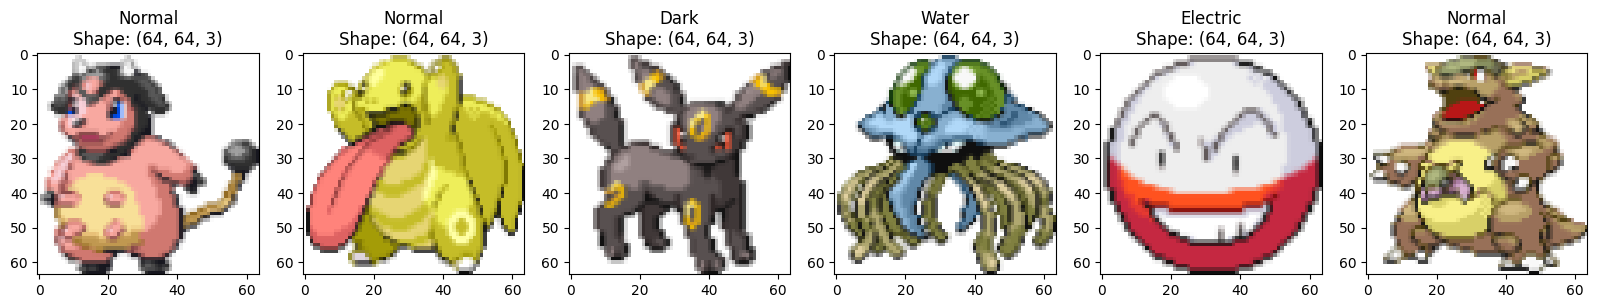

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/200


I0000 00:00:1713888677.118927   42243 service.cc:145] XLA service 0x7b83bc0145b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713888677.118951   42243 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1713888677.555410   42243 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1713888679.595759   42516 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1713888679.651303   42519 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1713888697.843056   42243 device_compiler.h:188] Com

127/127 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - loss: 0.3997
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.1465
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0978
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.1183
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0730
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.1038
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0925
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0810
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0873
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0755
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0563
Epoch 12/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0861
Epoch 13/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0654
Epoch 14/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0912
Epoch 15/200


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.00it/s]


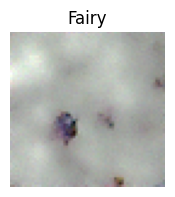

127/127 ━━━━━━━━━━━━━━━━━━━━ 66s 519ms/step - loss: 0.0671
Epoch 21/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0700
Epoch 22/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0490
Epoch 23/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0866
Epoch 24/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0640
Epoch 25/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0611
Epoch 26/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0386
Epoch 27/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0556
Epoch 28/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0983
Epoch 29/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0820
Epoch 30/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0784
Epoch 31/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0704
Epoch 32/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0580
Epoch 33/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0663
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.61it/s]


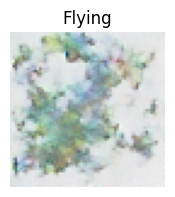

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 511ms/step - loss: 0.0450
Epoch 41/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0475
Epoch 42/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0823
Epoch 43/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0578
Epoch 44/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0395
Epoch 45/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0677
Epoch 46/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0639
Epoch 47/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0558
Epoch 48/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0795
Epoch 49/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0539
Epoch 50/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0452
Epoch 51/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0629
Epoch 52/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0581
Epoch 53/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0429
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.41it/s]


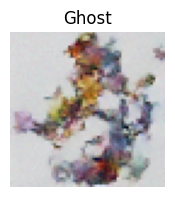

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0484
Epoch 61/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0437
Epoch 62/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0426
Epoch 63/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0559
Epoch 64/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0464
Epoch 65/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0639
Epoch 66/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0620
Epoch 67/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0549
Epoch 68/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0537
Epoch 69/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0510
Epoch 70/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0699
Epoch 71/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0706
Epoch 72/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0431
Epoch 73/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0619
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.05it/s]


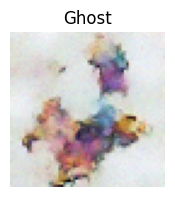

127/127 ━━━━━━━━━━━━━━━━━━━━ 66s 519ms/step - loss: 0.0632
Epoch 81/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0634
Epoch 82/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0477
Epoch 83/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0435
Epoch 84/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0502
Epoch 85/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0491
Epoch 86/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0530
Epoch 87/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0576
Epoch 88/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0808
Epoch 89/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0733
Epoch 90/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0585
Epoch 91/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0467
Epoch 92/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0415
Epoch 93/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0415
Epoch

Sampling sprite: 100%|██████████| 999/999 [00:44<00:00, 22.52it/s]


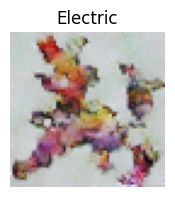

127/127 ━━━━━━━━━━━━━━━━━━━━ 67s 527ms/step - loss: 0.0550
Epoch 101/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0503
Epoch 102/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0699
Epoch 103/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0675
Epoch 104/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0619
Epoch 105/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0324
Epoch 106/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0640
Epoch 107/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0438
Epoch 108/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0571
Epoch 109/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0415
Epoch 110/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0674
Epoch 111/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0643
Epoch 112/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0546
Epoch 113/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.07it/s]


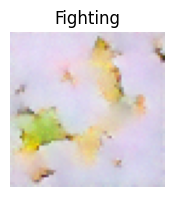

127/127 ━━━━━━━━━━━━━━━━━━━━ 66s 518ms/step - loss: 0.0604
Epoch 121/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0745
Epoch 122/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0609
Epoch 123/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0406
Epoch 124/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0519
Epoch 125/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0441
Epoch 126/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0598
Epoch 127/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0602
Epoch 128/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0586
Epoch 129/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0387
Epoch 130/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0700
Epoch 131/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0525
Epoch 132/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0506
Epoch 133/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 22.77it/s]


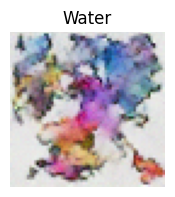

127/127 ━━━━━━━━━━━━━━━━━━━━ 66s 523ms/step - loss: 0.0488
Epoch 141/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0396
Epoch 142/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0477
Epoch 143/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0363
Epoch 144/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0454
Epoch 145/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0790
Epoch 146/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0637
Epoch 147/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0730
Epoch 148/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0717
Epoch 149/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0653
Epoch 150/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0447
Epoch 151/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0520
Epoch 152/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0369
Epoch 153/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:45<00:00, 21.78it/s]


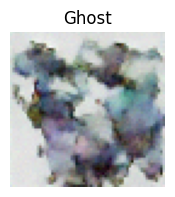

127/127 ━━━━━━━━━━━━━━━━━━━━ 68s 539ms/step - loss: 0.0775
Epoch 161/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0420
Epoch 162/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0403
Epoch 163/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0515
Epoch 164/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0355
Epoch 165/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0336
Epoch 166/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0528
Epoch 167/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0512
Epoch 168/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0501
Epoch 169/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0721
Epoch 170/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0540
Epoch 171/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0409
Epoch 172/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0374
Epoch 173/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:44<00:00, 22.59it/s]


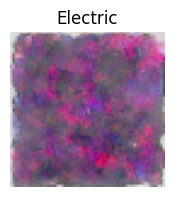

127/127 ━━━━━━━━━━━━━━━━━━━━ 66s 526ms/step - loss: 0.0548
Epoch 181/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0795
Epoch 182/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0571
Epoch 183/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0384
Epoch 184/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0395
Epoch 185/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0297
Epoch 186/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0387
Epoch 187/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0670
Epoch 188/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0505
Epoch 189/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0726
Epoch 190/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0529
Epoch 191/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0448
Epoch 192/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0552
Epoch 193/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:44<00:00, 22.65it/s]


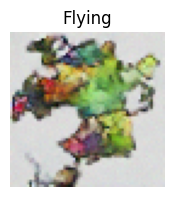

127/127 ━━━━━━━━━━━━━━━━━━━━ 66s 524ms/step - loss: 0.0346


In [6]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 22.86it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:44<00:00, 22.64it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 22.84it/s]


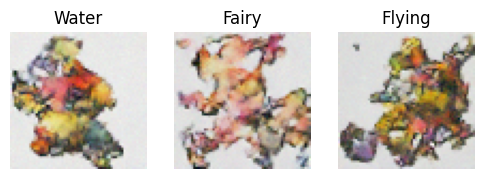

In [7]:
model.plot_samples(3)

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.09it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:45<00:00, 21.87it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:46<00:00, 21.47it/s]


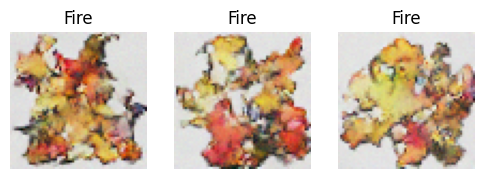

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:44<00:00, 22.54it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:44<00:00, 22.70it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 22.71it/s]


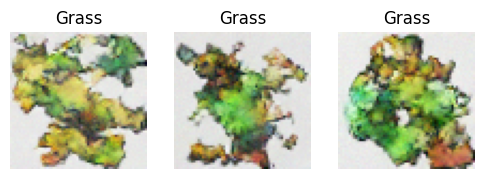

Generating sample 1/3


Sampling sprite: 100%|██████████| 999/999 [00:44<00:00, 22.47it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 999/999 [00:45<00:00, 22.06it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 999/999 [00:46<00:00, 21.63it/s]


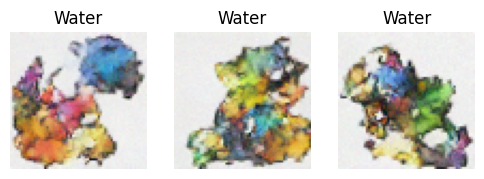

In [12]:
model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [9]:
# import gradio as gr

# poke_diffusion = gr.Interface(
#     fn=model.plot_samples,
#     inputs=gr.Slider(minimum=1, maximum=10, label="Number of samples"),
#     outputs=gr.Image(),
# )

# poke_diffusion.launch(share=True)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [10]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [11]:
# Save the model
# model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

# save_model(model, model_name)

[BACK TO TOP](#top)